## Introduction
The dataset used for this project is an E-commerce Data set containing actual transactions from a UK retailer and shared on Kaggle at https://www.kaggle.com/datasets/carrie1/ecommerce-data/data.

The data is made up of a single csv containing over 540,000 rows.

Using this data, we're going to use unsupervised learning to fit the Customer's into clusters based on their spending.

## Imports
All libraries imported

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt, pi
from sklearn.neighbors import NearestNeighbors

## Read Data
Read in the data. The default UTF caused errors, so we used ISO-8859-1.

In [2]:
file_path = 'data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


## Minimal EDA
Let's take a look at the dataset to get a feel for it's contents.
First we look at UnitPrice. Let's get a feel for the range, max and min values
Then we look at Quantity

Maximum Unit Price: 38970.0
Minimum Unit Price: -11062.06
Number of UnitPrice values over 500: 255
Number of UnitPrice values over 1000: 120


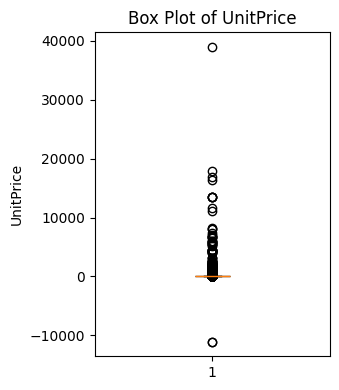

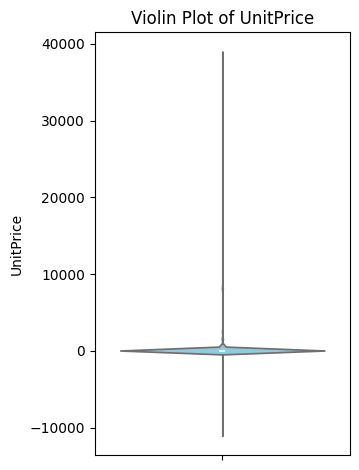

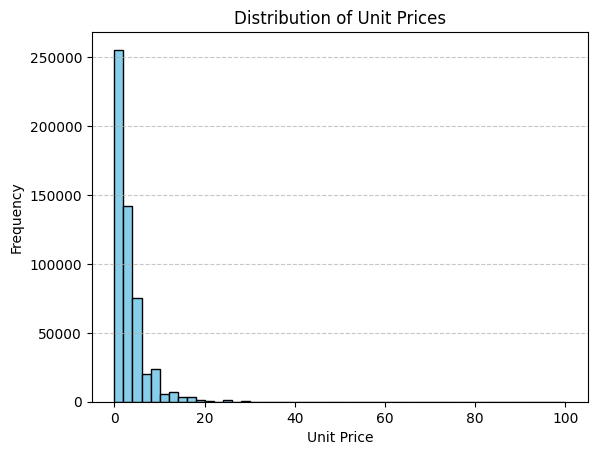

In [4]:
# Show the maximum & minimum value of UnitPrice
max_unit_price = data['UnitPrice'].max()
min_unit_price = data['UnitPrice'].min()
print("Maximum Unit Price:", max_unit_price)
print("Minimum Unit Price:", min_unit_price)

# Count the number of UnitPrice values greater than 500
unit_price_over_500 = (data['UnitPrice'] > 500).sum()
print("Number of UnitPrice values over 500:", unit_price_over_500)

# Count the number of UnitPrice values greater than 1000
unit_price_over_1000 = (data['UnitPrice'] > 1000).sum()
print("Number of UnitPrice values over 1000:", unit_price_over_1000)

# Boxplot for UnitPrice
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.boxplot(data['UnitPrice'], vert=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Box Plot of UnitPrice')
plt.ylabel('UnitPrice')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
sns.violinplot(y=data['UnitPrice'], color='skyblue')
plt.title('Violin Plot of UnitPrice')
plt.tight_layout()
plt.show()

plt.hist(data['UnitPrice'], bins=50, range=(0, 100), edgecolor='black', color='skyblue')
plt.title('Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
# Count the number of UnitPrice values less than 0
unit_price_over_100 = (data['UnitPrice'] < 0).sum()
print("Number of UnitPrice values less than 0:", unit_price_over_100)

rows_price_negative = data[(data['UnitPrice'] < 0)]
print("Rows with UnitPrice < 0:")
print(rows_price_negative)

Number of UnitPrice values less than 0: 2
Rows with UnitPrice < 0:
       InvoiceNo StockCode      Description  Quantity      InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  8/12/2011 14:51   
299984   A563187         B  Adjust bad debt         1  8/12/2011 14:52   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom  


Maximum Quantity: 80995
Minimum Quantity: -80995
Quantity values over 60000: 2


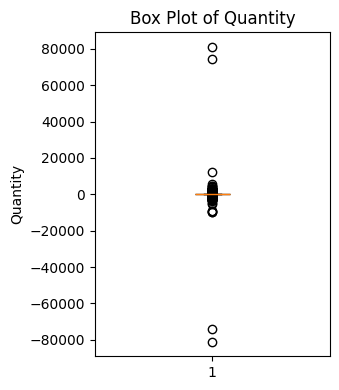

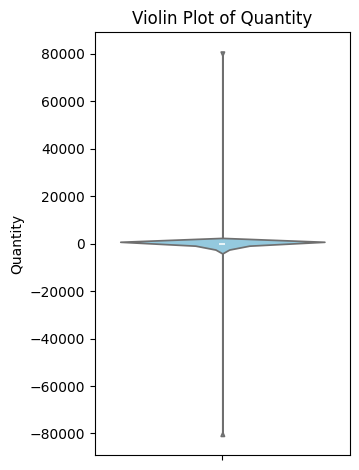

In [6]:
# Show the maximum & minimum value of Quantity
max_quantity = data['Quantity'].max()
min_quantity = data['Quantity'].min()
print("Maximum Quantity:", max_quantity)
print("Minimum Quantity:", min_quantity)

# Count the number of Quantity values greater than 60000
quantity_over_60000 = (data['Quantity'] > 60000).sum()
print("Quantity values over 60000:", quantity_over_60000)

# Boxplot for Quantity
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.boxplot(data['Quantity'], vert=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Box Plot of Quantity')
plt.ylabel('Quantity')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
sns.violinplot(y=data['Quantity'], color='skyblue')
plt.title('Violin Plot of Quantity')
plt.tight_layout()
plt.show()

## Negative quantity means the item was returned
Let's verify that the same CustomerID returned the major items

In [7]:
# Filter rows where Quantity over 60000
rows_quantity_over_60000 = data[(data['Quantity'] > 60000) | (data['Quantity'] < -60000)]
print("Rows with Quantity > 60000:")
print(rows_quantity_over_60000)

Rows with Quantity > 60000:
       InvoiceNo StockCode                     Description  Quantity  \
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   
540421    581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   
540422   C581484     23843     PAPER CRAFT , LITTLE BIRDIE    -80995   

            InvoiceDate  UnitPrice  CustomerID         Country  
61619   1/18/2011 10:01       1.04     12346.0  United Kingdom  
61624   1/18/2011 10:17       1.04     12346.0  United Kingdom  
540421   12/9/2011 9:15       2.08     16446.0  United Kingdom  
540422   12/9/2011 9:27       2.08     16446.0  United Kingdom  


## Check for missing or null values
Let's check for missing or null values. DBSCAN doesn't play well with null values

In [8]:
# Check for missing or null values in cells
missing_values = data.isnull().sum()
print("Missing Values per Column:\n", missing_values)

# Check for the number of unique CustomerID
unique_customers = data['CustomerID'].nunique()
print("\nNumber of Unique Customers:", unique_customers)

# Check for the number of unique Countries
unique_countries = data['Country'].nunique()
print("Number of Unique Countries:", unique_countries)

Missing Values per Column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Number of Unique Customers: 4372
Number of Unique Countries: 38


## Investigate CustomerID null number
The number of null CustomerID rows are pretty high (135080). These may be shoppers that are not logged in. We want to remove these, but first, let's take a random sampling of five of such records

In [9]:
null_customer_rows = data[data['CustomerID'].isnull()]
random_null_rows = null_customer_rows.sample(n=5, random_state=42)
print("5 Random Rows where CustomerID is Null:")
print(random_null_rows)

5 Random Rows where CustomerID is Null:
       InvoiceNo StockCode                        Description  Quantity  \
107790    545464     22624               IVORY KITCHEN SCALES         1   
181708    552508     22998       TRAVEL CARD WALLET KEEP CALM         2   
61217     541424     22335     HEART DECORATION PAINTED ZINC          1   
169305    551173    84970S  HANGING HEART ZINC T-LIGHT HOLDER         5   
238450    557938     23205    CHARLOTTE BAG VINTAGE ALPHABET          1   

            InvoiceDate  UnitPrice  CustomerID         Country  
107790    3/3/2011 9:10       8.50         NaN  United Kingdom  
181708   5/9/2011 16:27       0.83         NaN  United Kingdom  
61217   1/17/2011 17:57       1.25         NaN  United Kingdom  
169305  4/26/2011 16:54       2.08         NaN  United Kingdom  
238450  6/23/2011 15:35       1.63         NaN  United Kingdom  


## Remove rows
Remove all rows where CustomerID is null.

In [10]:
data = data.dropna(subset=['CustomerID'])

## Procedure
For this project, we're going to experiment with KMeans and DBSCAN.
Since we want to group customers based on their spending, we would need to modify the dataset into a new dataframe.
The features we're going to look at include
1. Total_Spend - Total amount spent, which is Sum of (UnitPrice * Quantity)
2. Invoice_Count - Total times customer has shopped
3. Frequency - Total number of unique items bought by customer
4. Total_Returns - Total amount of items returned
5. Return_Frequency - Total number of unique items returned
6. Avg_Spend - Average spend by customer

In [11]:
# Group by CustomerID and compute required metrics
customer_grouped = data.groupby('CustomerID').agg(
    Total_Spend=('UnitPrice', lambda x: (data.loc[x.index, 'Quantity'] * x).sum()),
    Invoice_Count=('InvoiceNo', 'nunique'),
    Frequency=('InvoiceNo', lambda x: x.count()),
    Total_Returns=('UnitPrice', lambda x: (data.loc[x.index, 'Quantity'][data.loc[x.index, 'Quantity'] < 0] * x[data.loc[x.index, 'Quantity'] < 0]).sum()),
    Return_Frequency=('InvoiceNo', lambda x: data.loc[x.index][data.loc[x.index, 'Quantity'] < 0]['InvoiceNo'].count())
)
customer_grouped['Avg_Spend'] = customer_grouped['Total_Spend'] / customer_grouped['Invoice_Count']

# Display the result
print(customer_grouped.reset_index())

      CustomerID  Total_Spend  Invoice_Count  Frequency  Total_Returns  \
0        12346.0         0.00              2          2      -77183.60   
1        12347.0      4310.00              7        182           0.00   
2        12348.0      1797.24              4         31           0.00   
3        12349.0      1757.55              1         73           0.00   
4        12350.0       334.40              1         17           0.00   
...          ...          ...            ...        ...            ...   
4367     18280.0       180.60              1         10           0.00   
4368     18281.0        80.82              1          7           0.00   
4369     18282.0       176.60              3         13          -1.45   
4370     18283.0      2094.88             16        756           0.00   
4371     18287.0      1837.28              3         70           0.00   

      Return_Frequency    Avg_Spend  
0                    1     0.000000  
1                    0   615.714286

## Heirarchical Clustering
Let's normalize and generate a heirarchical cluster

In [12]:
# Normalize the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_grouped)

# Hierarchical Clustering
linked = linkage(scaled_data, method='ward')

## Plot a dendogram

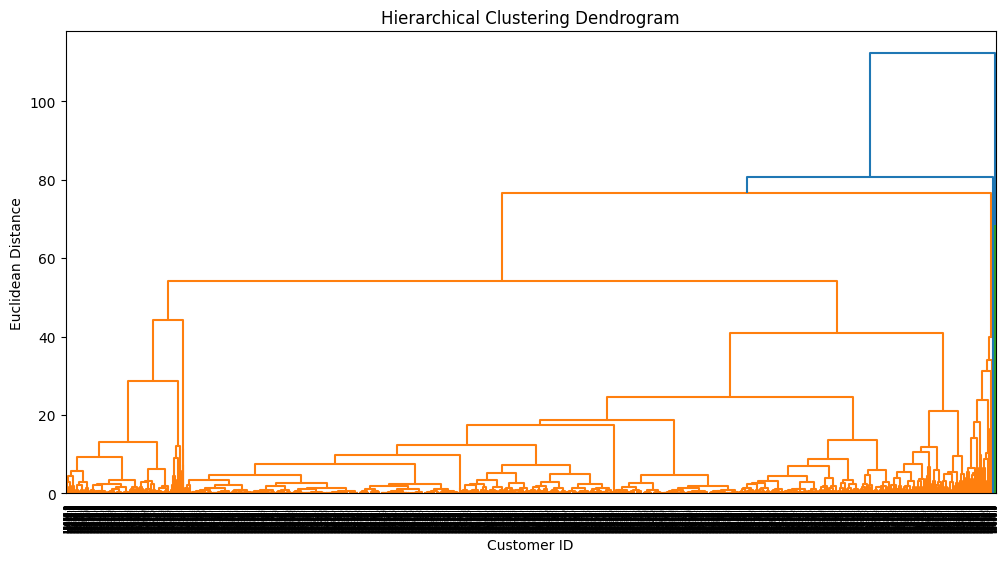

In [13]:
plt.figure(figsize=(12, 6))
dendrogram(linked, 
           labels=customer_grouped.index, 
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customer ID")
plt.ylabel("Euclidean Distance")
plt.show()

## KMeans
Let's attempt to cluster with KMeans

In [14]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
feature_columns = ['Total_Spend', 'Invoice_Count', 'Total_Returns', 'Return_Frequency', 'Frequency', 'Avg_Spend']
cluster_summary = pd.DataFrame(cluster_centers, columns=feature_columns)


Cluster Centers (Unscaled):
     Total_Spend  Invoice_Count  Total_Returns  Return_Frequency  Frequency  \
0     986.510228       3.522126      63.025958        -53.103854   0.966625   
1  102590.930714      98.142857    2638.071429     -15387.260714  62.500000   
2    9180.060415      20.987220     367.271565       -578.643291  13.162939   

     Avg_Spend  
0   288.293184  
1  1659.458527  
2   612.344754  

Cluster Analysis:
         Avg_Total_Spend  Avg_Invoice_Count   Avg_Returns  Return_Frequency  \
Cluster                                                                       
0             986.510228           3.522126    -53.103854          0.966625   
1          102590.930714          98.142857 -15387.260714         62.500000   
2            9180.060415          20.987220   -578.643291         13.162939   

           Frequency    Avg_Spend  Count  
Cluster                                   
0          63.025958   288.293184   4045  
1        2638.071429  1659.458527     14  


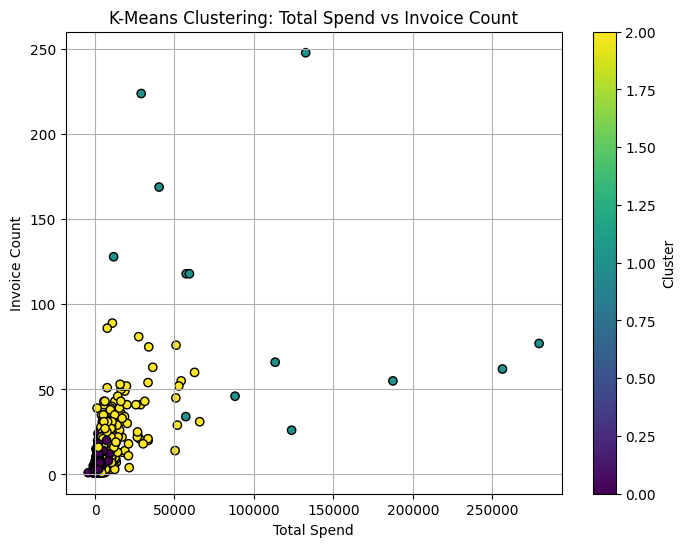

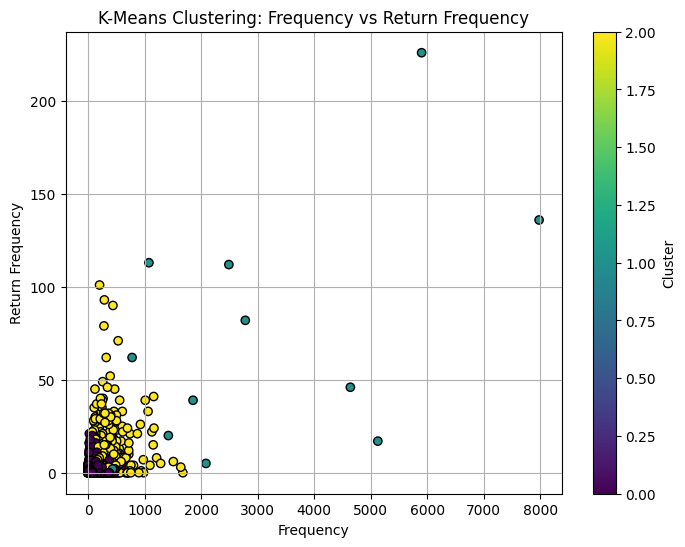

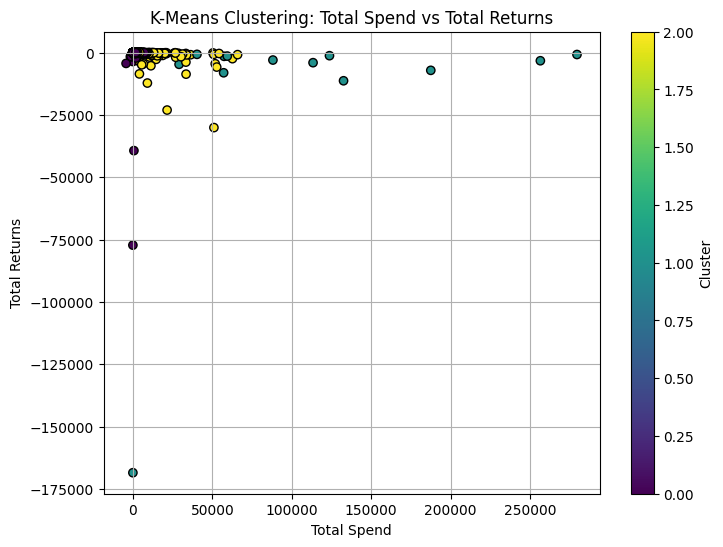

In [15]:
print("Cluster Centers (Unscaled):")
print(cluster_summary)

# Assign cluster labels to original data
customer_grouped['Cluster'] = kmeans.labels_

# Summary statistics for each cluster
cluster_analysis = customer_grouped.groupby('Cluster').agg(
    Avg_Total_Spend=('Total_Spend', 'mean'),
    Avg_Invoice_Count=('Invoice_Count', 'mean'),
    Avg_Returns=('Total_Returns', 'mean'),
    Return_Frequency=('Return_Frequency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Avg_Spend=('Avg_Spend', 'mean'),
    Count=('Cluster', 'size')
)

print("\nCluster Analysis:")
print(cluster_analysis)

# Calculate RMSE (Root Mean Squared Error)
rmse = sqrt(mean_squared_error(scaled_data, kmeans.cluster_centers_[kmeans.labels_]))
print("\nRoot Mean Squared Error (RMSE):", rmse)

# Step 8: Visualize the clusters (2D using Total_Spend vs Invoice_Count)
plt.figure(figsize=(8, 6))
plt.scatter(customer_grouped['Total_Spend'], 
            customer_grouped['Invoice_Count'], 
            c=customer_grouped['Cluster'], cmap='viridis', edgecolor='k')
plt.title('K-Means Clustering: Total Spend vs Invoice Count')
plt.xlabel('Total Spend')
plt.ylabel('Invoice Count')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(customer_grouped['Frequency'], 
            customer_grouped['Return_Frequency'], 
            c=customer_grouped['Cluster'], cmap='viridis', edgecolor='k')
plt.title('K-Means Clustering: Frequency vs Return Frequency')
plt.xlabel('Frequency')
plt.ylabel('Return Frequency')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(customer_grouped['Total_Spend'], 
            customer_grouped['Total_Returns'], 
            c=customer_grouped['Cluster'], cmap='viridis', edgecolor='k')
plt.title('K-Means Clustering: Total Spend vs Total Returns')
plt.xlabel('Total Spend')
plt.ylabel('Total Returns')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Let's see what features are most important

In [16]:
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=feature_columns)
feature_importance = cluster_centers_df.max() - cluster_centers_df.min()

# Sort and display the features by importance
feature_importance = feature_importance.sort_values(ascending=False)
print("Feature Importance Based on Cluster Centers:")
print(feature_importance)

Feature Importance Based on Cluster Centers:
Total_Spend         12.363034
Total_Returns       11.078084
Invoice_Count       10.133210
Frequency            8.383739
Return_Frequency     5.194222
Avg_Spend            3.796181
dtype: float64


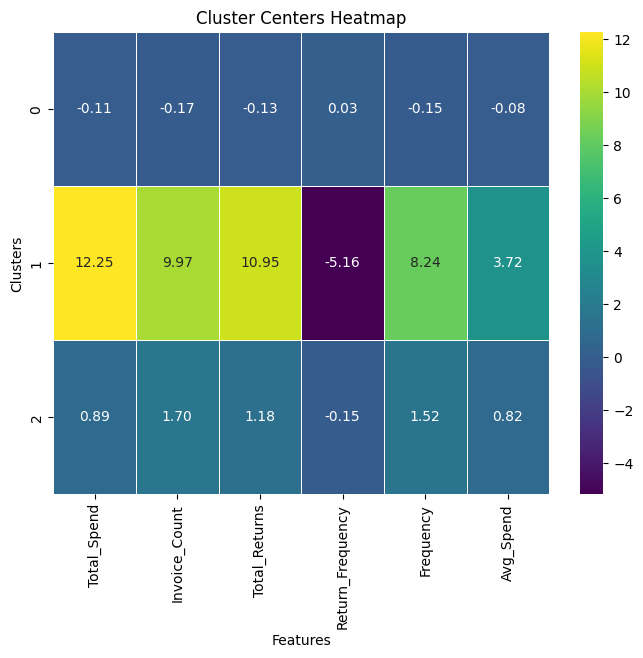

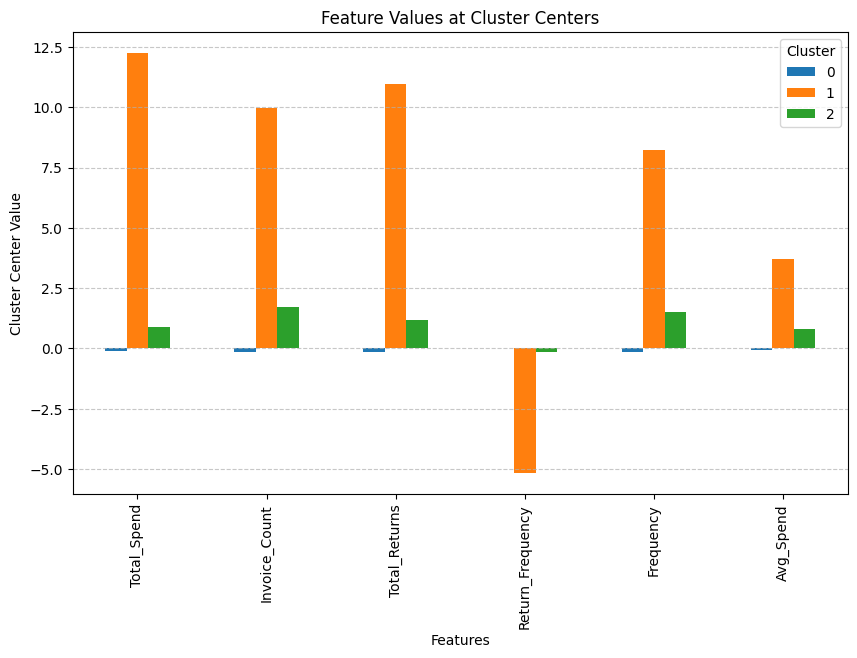

In [17]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_centers_df, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title('Cluster Centers Heatmap')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# Transpose for better visualization
cluster_centers_df_T = cluster_centers_df.T
# Plot bar plot for cluster centers
cluster_centers_df_T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Values at Cluster Centers')
plt.xlabel('Features')
plt.ylabel('Cluster Center Value')
plt.legend(title='Cluster')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Optimizations
Can we optimize?
Let's use Elbow method and Silhouette to determine the optimal k

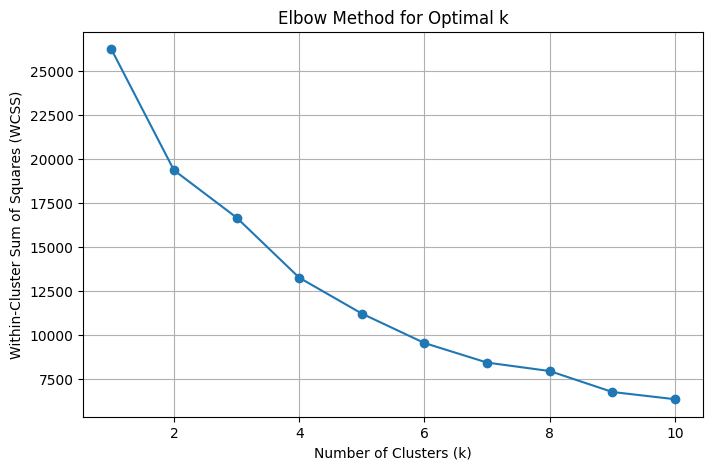

In [18]:
# Range of k values to test
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)  # Use standardized features
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

In [19]:
from sklearn.metrics import silhouette_score

# Test different values of k
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    print(f"For k = {k}, Silhouette Score = {score:.3f}")

For k = 2, Silhouette Score = 0.943
For k = 3, Silhouette Score = 0.701
For k = 4, Silhouette Score = 0.701
For k = 5, Silhouette Score = 0.702
For k = 6, Silhouette Score = 0.688
For k = 7, Silhouette Score = 0.635
For k = 8, Silhouette Score = 0.570
For k = 9, Silhouette Score = 0.531
For k = 10, Silhouette Score = 0.341


## Analysis
From Silhouette, we observe a stabilization between 3-5. While 2 clusters has the highest score, it would likely be an oversimplification.
For the Elbow method, there's a sharp decrease from 1-4, then the rate of decrease slows down. This indicates that 4 is the point where adding more clusters results in only minor improvements.

### Results
From the visualizations we can infer that the 3 clusters seem to be
* Cluster 0 - Customers with low transaction volume
* Cluster 1 - Customers with high transaction volumes
* Cluster 2 - Customers with average transaction volumes

## Let's take a look at DBSCAN

In [20]:
# Group by CustomerID and compute required metrics
customer_grouped_dbscan = data.groupby('CustomerID').agg(
    Total_Spend=('UnitPrice', lambda x: (data.loc[x.index, 'Quantity'] * x).sum()),
    Invoice_Count=('InvoiceNo', 'nunique'),
    Frequency=('InvoiceNo', lambda x: x.count()),
    Total_Returns=('UnitPrice', lambda x: (data.loc[x.index, 'Quantity'][data.loc[x.index, 'Quantity'] < 0] * x[data.loc[x.index, 'Quantity'] < 0]).sum()),
    Return_Frequency=('InvoiceNo', lambda x: data.loc[x.index][data.loc[x.index, 'Quantity'] < 0]['InvoiceNo'].count())
)
customer_grouped_dbscan['Avg_Spend'] = customer_grouped['Total_Spend'] / customer_grouped['Invoice_Count']

#customer_grouped['Frequency'] = data.groupby('CustomerID')['InvoiceNo'].count()
# Features to use for DBSCAN
#features_dbscan = ['Total_Spend', 'Invoice_Count', 'Frequency']
features_dbscan = ['Total_Spend', 'Invoice_Count', 'Total_Returns', 'Return_Frequency', 'Frequency', 'Avg_Spend']

# Standardize the features
scaler_dbscan = StandardScaler()
scaled_features_dbscan = scaler_dbscan.fit_transform(customer_grouped_dbscan[features_dbscan])

# Display the result
print(customer_grouped_dbscan.reset_index())

      CustomerID  Total_Spend  Invoice_Count  Frequency  Total_Returns  \
0        12346.0         0.00              2          2      -77183.60   
1        12347.0      4310.00              7        182           0.00   
2        12348.0      1797.24              4         31           0.00   
3        12349.0      1757.55              1         73           0.00   
4        12350.0       334.40              1         17           0.00   
...          ...          ...            ...        ...            ...   
4367     18280.0       180.60              1         10           0.00   
4368     18281.0        80.82              1          7           0.00   
4369     18282.0       176.60              3         13          -1.45   
4370     18283.0      2094.88             16        756           0.00   
4371     18287.0      1837.28              3         70           0.00   

      Return_Frequency    Avg_Spend  
0                    1     0.000000  
1                    0   615.714286

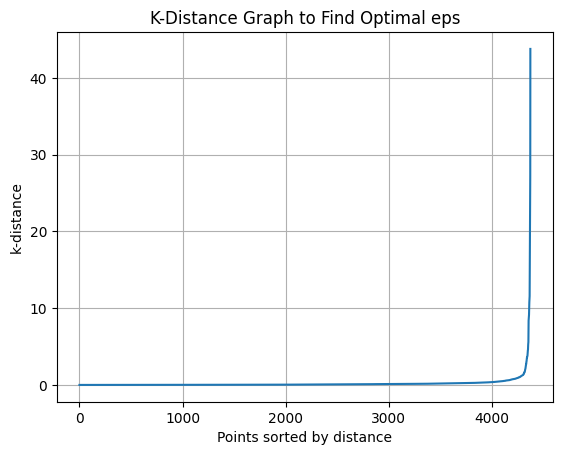

In [21]:
# Find the k-nearest neighbors
k = 3  # Use 4 neighbors (min_samples)
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(scaled_features_dbscan)
distances, indices = neighbors_fit.kneighbors(scaled_features_dbscan)

# Sort and plot distances
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title('K-Distance Graph to Find Optimal eps')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.grid()
plt.show()


## Optimizations
From the plot above, we can see that there's a sharp change at k-distance equal 1 - 2.
We'll experiment with eps values between 0.5 - 2 and features between 4 - 6.
While we have 6 features, not all might be useful.

            Total_Spend  Invoice_Count  Frequency  Total_Returns  \
CustomerID                                                         
12346.0            0.00              2          2      -77183.60   
12347.0         4310.00              7        182           0.00   
12348.0         1797.24              4         31           0.00   
12349.0         1757.55              1         73           0.00   
12350.0          334.40              1         17           0.00   
...                 ...            ...        ...            ...   
18280.0          180.60              1         10           0.00   
18281.0           80.82              1          7           0.00   
18282.0          176.60              3         13          -1.45   
18283.0         2094.88             16        756           0.00   
18287.0         1837.28              3         70           0.00   

            Return_Frequency    Avg_Spend  Cluster  
CustomerID                                          
12346.0  

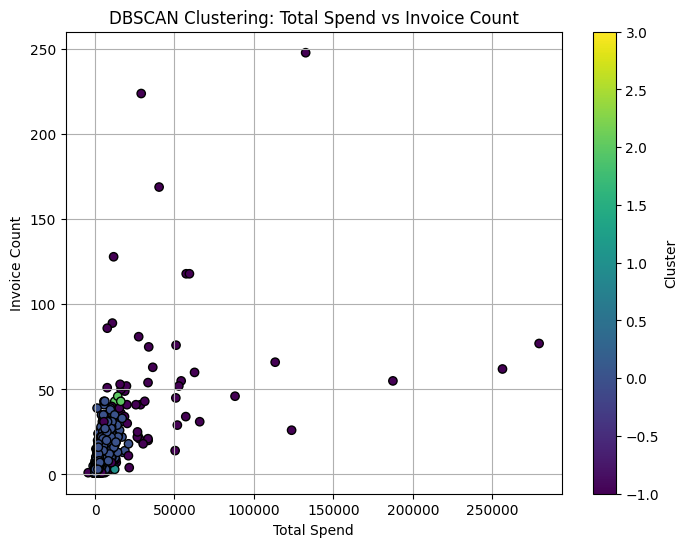

In [22]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=4)
dbscan_labels = dbscan.fit_predict(scaled_features_dbscan)

# Add cluster labels to the original DataFrame
customer_grouped_dbscan['Cluster'] = dbscan_labels

# Display the results
print(customer_grouped_dbscan)

# Find core samples (core points) and labels
core_samples = dbscan.core_sample_indices_
core_points = scaled_features_dbscan[core_samples]

# Calculate distances to nearest core point
distances = []
for i, point in enumerate(scaled_features_dbscan):
    if dbscan_labels[i] != -1:  # Skip noise points
        # Compute distance to nearest core point within the same cluster
        cluster_core_points = core_points[dbscan_labels[core_samples] == dbscan_labels[i]]
        min_distance = np.min(np.linalg.norm(cluster_core_points - point, axis=1))
        distances.append(min_distance)

# Calculate RMSE
rmse_dbscan = sqrt(np.mean(np.square(distances)))
print("Root Mean Squared Error (RMSE):", rmse_dbscan)

print("Number of Noise Points:", (dbscan_labels == -1).sum())

plt.figure(figsize=(8, 6))
plt.scatter(customer_grouped_dbscan['Total_Spend'], 
            customer_grouped_dbscan['Invoice_Count'], 
            c=customer_grouped_dbscan['Cluster'], cmap='viridis', edgecolor='k')
plt.title('DBSCAN Clustering: Total Spend vs Invoice Count')
plt.xlabel('Total Spend')
plt.ylabel('Invoice Count')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


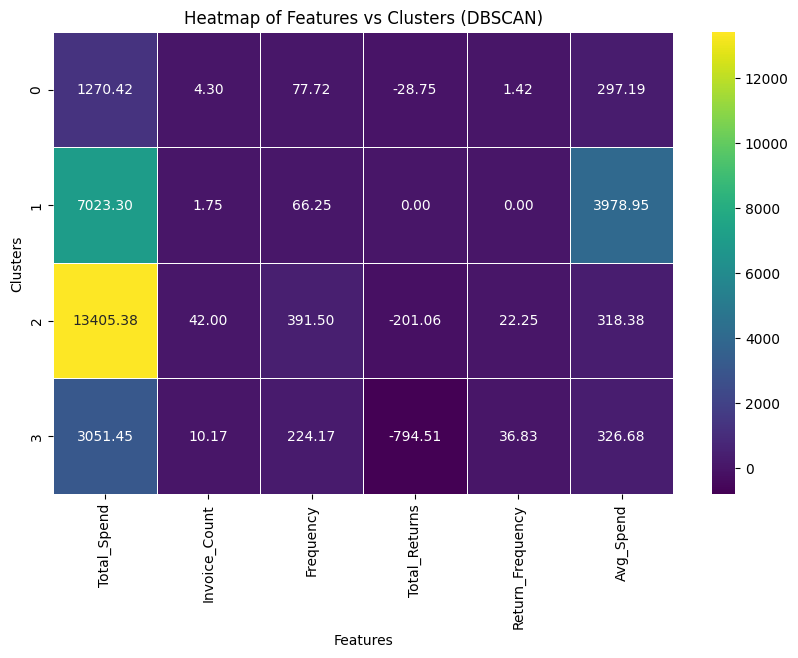

<Figure size 1000x600 with 0 Axes>

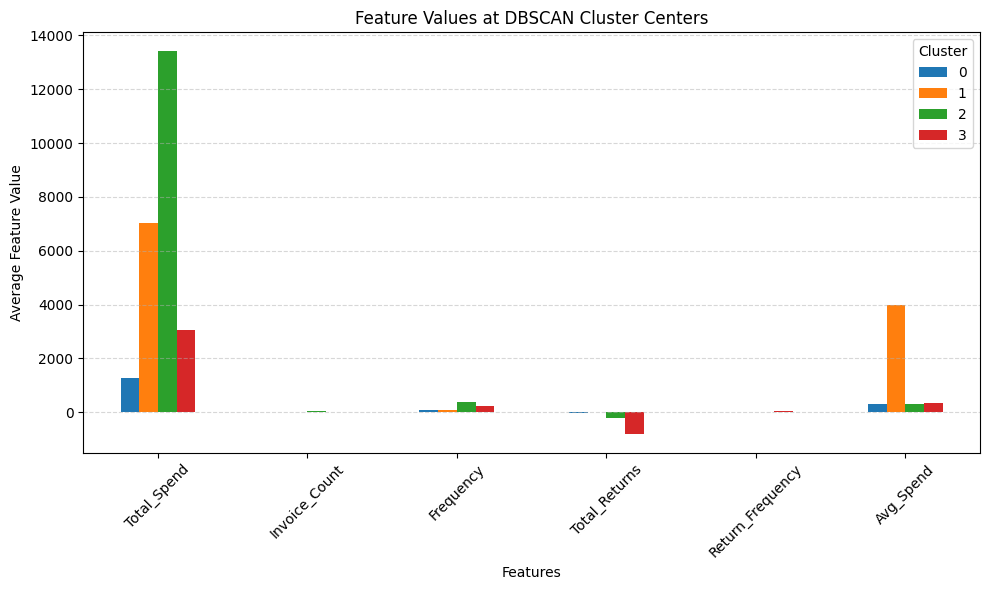

In [23]:
# Filter out noise points (Cluster = -1)
clustered_data = customer_grouped_dbscan[customer_grouped_dbscan['Cluster'] != -1]

# Calculate mean feature values for each cluster
cluster_means = clustered_data.groupby('Cluster').mean()

# Generate a heatmap of features vs clusters
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Features vs Clusters (DBSCAN)')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# Transpose for better visualization
cluster_means_transposed = cluster_means.T
# Plot a bar chart of feature values for each cluster
plt.figure(figsize=(10, 6))
cluster_means_transposed.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Values at DBSCAN Cluster Centers')
plt.xlabel('Features')
plt.ylabel('Average Feature Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Analysis
We can identify four major clusters
* Customers with a high Total Spend
* Customers with high returns but not high spenders
* Customers with a high average spend
* Customers with low transaction volume

## Comparison of DBSCAN and KMeans
| Feature/Result | DBSCAN | KMeans |
|----------------|--------|--------|
| RMSE           | 0.064  | 0.711  |
| Number of Clusters | 4  | 3      |
| Has cluster for high Total Spend | Y  | Y   |
| Has cluster for high Returns | Y  | N   |
| Has cluster for high Average Spend | Y  | N   |
| Has cluster for low spenders | Y  | Y   |
| Has cluster for average spenders | N  | Y   |

### General Outcome
For this particular dataset, DBSCAN outperforms KMeans as evidenced by it's lower RMSE, which indicates that it better handled outliers and the cluster formation.

### Optimizations
While we manually updated the optimal values for this project, in a future iteration, we would want to generate various results based on various values of k (for KMeans) and eps and number of features (for DBSCAN)

### Visualizations
Both methods generated pretty easy to distinguish heatmaps and plots. The clusters are well defined.

### Customer Clusters
For the selected values for this project, KMeans generated three (3) clusters, for High, Medium and Low spenders. DBSCAN generated four clusters for High Total Spenders, High Returns (but not High Spenders), High Average Spenders and Low Spenders.

### Observations and Future Work
Time constraint aside, we would be interested in expanding this project in the following ways
* Generate multiple result sets with different optimizations for better comparison
* Test other density based methods, such as HDBSCAN
* Modify the number of features to identify the best performers
* Investigate ways to validate the generated clusters. We're unable to validate the results provided by our model.